<a href="https://colab.research.google.com/github/dejunga/ML-Vehicle_Image_Classification/blob/main/DenseNet_model_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# **Load the dataset**

In [19]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Define the desired labels (airplane, automobile, ship, and truck)
classes_name = ['airplane', 'automobile', 'ship', 'truck']
desired_indices = [labels.index(label) for label in classes_name]

# Filter the training dataset to include only images with the desired labels
mask_train = np.isin(y_train, desired_indices).flatten()
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# Filter the test dataset to include only images with the desired labels
mask_test = np.isin(y_test, desired_indices).flatten()
X_test = X_test[mask_test]
y_test = y_test[mask_test]

# Print the shapes of the filtered datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (20000, 32, 32, 3)
y_train shape: (20000, 1)
X_test shape: (4000, 32, 32, 3)
y_test shape: (4000, 1)


# **Data visualization**

<ipython-input-20-6a9508f2eb8f>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


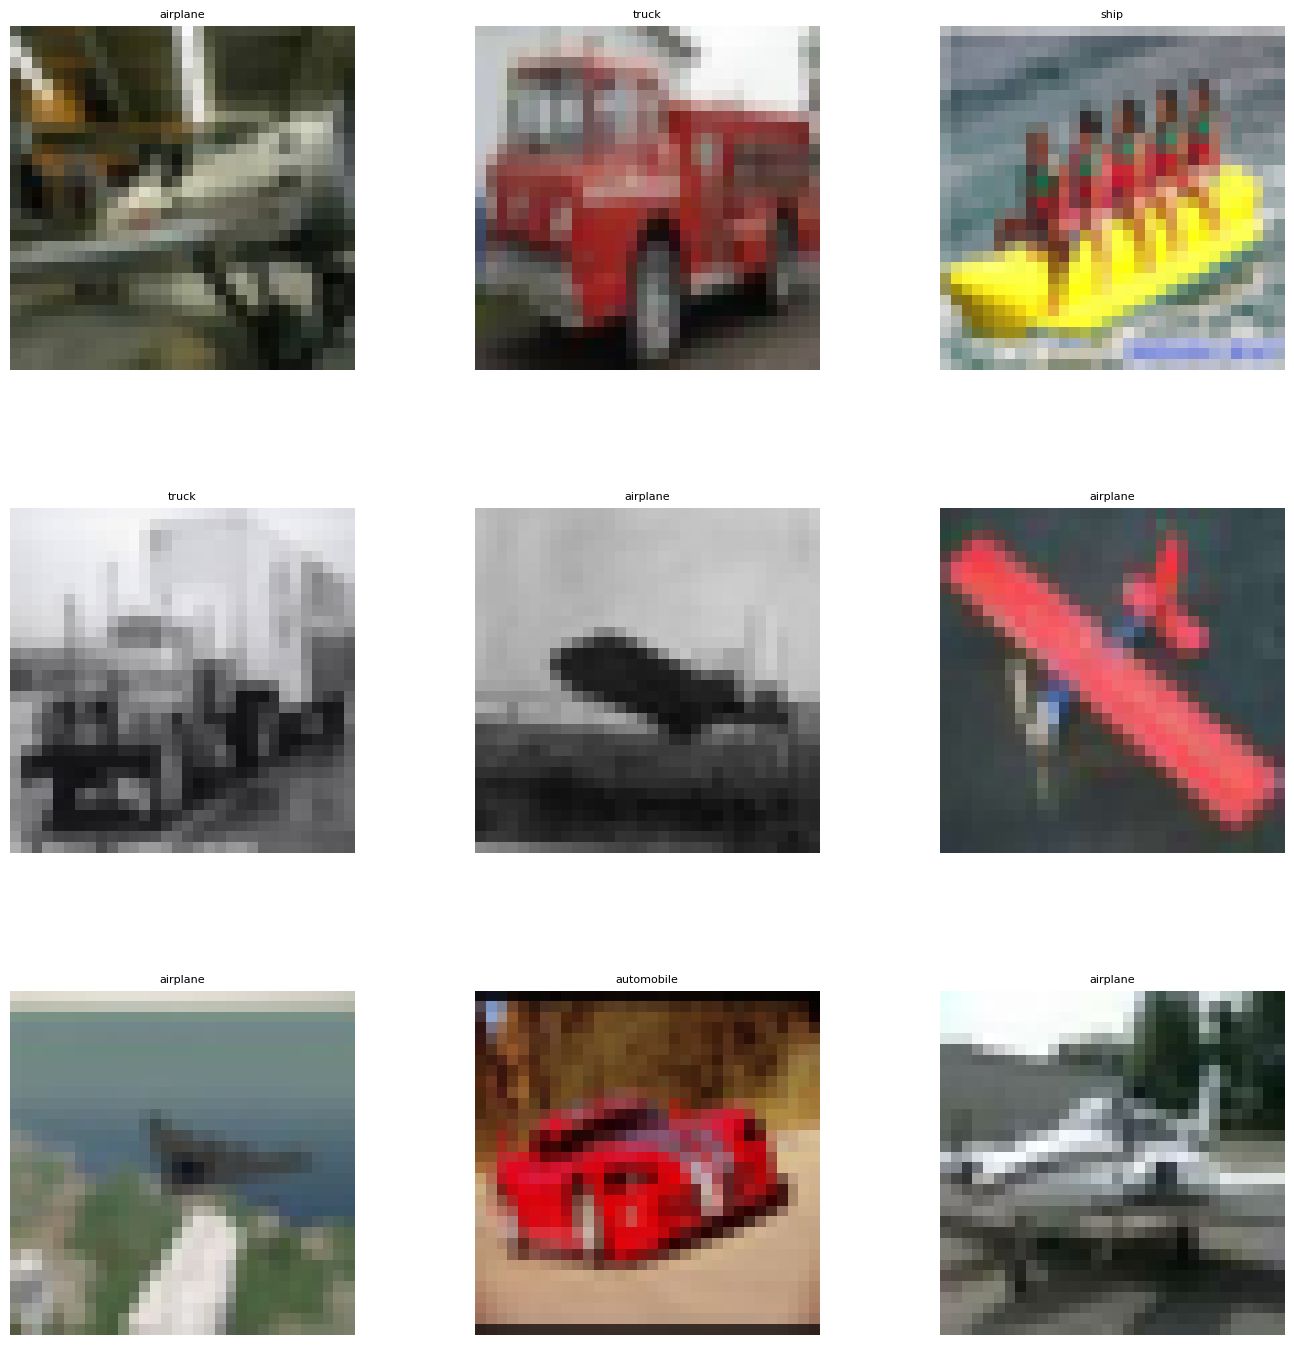

In [20]:
W_grid = 3
L_grid = 3

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()  # Flatten the 10 x 10 matrix into 100 array

n_filtered = len(X_train)  # get the length of the filtered dataset

# Select a random number from 0 to n_filtered
for i in np.arange(0, W_grid * L_grid):  # create evenly spaced variables

    # Select a random number
    index = np.random.randint(0, n_filtered)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index])

    # Get the corresponding label index
    label_index = int(y_train[index])

    # Display the corresponding label name
    axes[i].set_title(labels[label_index], fontsize=8)

    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)
plt.show()

# **Data preprocessing**

In [21]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [22]:
# number of classes
K = len(set(y_train.flatten())) # Flatten the array to get a 1D array of hashable values

# calculate total number of classes
# for output layer
print("number of classes:", K)

number of classes: 4


In [23]:
np.isnan(X_train).any()

False

In [29]:
np.isnan(X_test).any()

False

# **DenseNet**

In [30]:
import time
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Load DenseNet121 model without top layers
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Custom model
model_densenet = Sequential()

# Add DenseNet base
model_densenet.add(densenet_base)

# Global average pooling
model_densenet.add(GlobalAveragePooling2D())

# Fully connected layer
model_densenet.add(Dense(512, activation='relu'))
model_densenet.add(Dropout(0.25))

# Output layer
model_densenet.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model_densenet.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=METRICS)


# Data augmentation
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size


# Track training time
start_time = time.time()

# Train the model
history_densenet = model_densenet.fit(train_generator,
                                      epochs=20,
                                      steps_per_epoch=steps_per_epoch,
                                      validation_data=(X_test, y_cat_test))


# End time
end_time = time.time()
training_time = end_time - start_time

# Memory usage (for GPU, if available)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
memory_usage = None
if gpu_devices:
    memory_info = tf.config.experimental.get_memory_info('GPU:0')
    memory_usage = memory_info['peak'] / (1024 ** 2)  # Convert bytes to MB

# Print training time and memory usage
print(f"Training Time: {training_time:.2f} seconds")
if memory_usage:
    print(f"Peak GPU Memory Usage: {memory_usage:.2f} MB")

# Additional metrics like accuracy, precision, recall can be obtained from history_densenet
final_accuracy = max(history_densenet.history['accuracy'])
final_precision = max(history_densenet.history['precision'])
final_recall = max(history_densenet.history['recall'])

# Print the final results for the DenseNet model
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final Recall: {final_recall:.4f}")

Epoch 1/20
625/625 [==============================] - 176s 235ms/step - loss: 0.8110 - accuracy: 0.7153 - precision: 0.7661 - recall: 0.6557 - val_loss: 0.5934 - val_accuracy: 0.7780 - val_precision: 0.7943 - val_recall: 0.7605
Epoch 2/20
625/625 [==============================] - 145s 233ms/step - loss: 0.4618 - accuracy: 0.8304 - precision: 0.8564 - recall: 0.8037 - val_loss: 0.5710 - val_accuracy: 0.7995 - val_precision: 0.8159 - val_recall: 0.7845
Epoch 3/20
625/625 [==============================] - 146s 233ms/step - loss: 0.3834 - accuracy: 0.8635 - precision: 0.8835 - recall: 0.8433 - val_loss: 0.5149 - val_accuracy: 0.8055 - val_precision: 0.8235 - val_recall: 0.7840
Epoch 4/20
625/625 [==============================] - 145s 233ms/step - loss: 0.3609 - accuracy: 0.8694 - precision: 0.8868 - recall: 0.8514 - val_loss: 0.3449 - val_accuracy: 0.8848 - val_precision: 0.8936 - val_recall: 0.8777
Epoch 5/20
625/625 [==============================] - 144s 230ms/step - loss: 0.2947 - a

# **Model Evaluation**

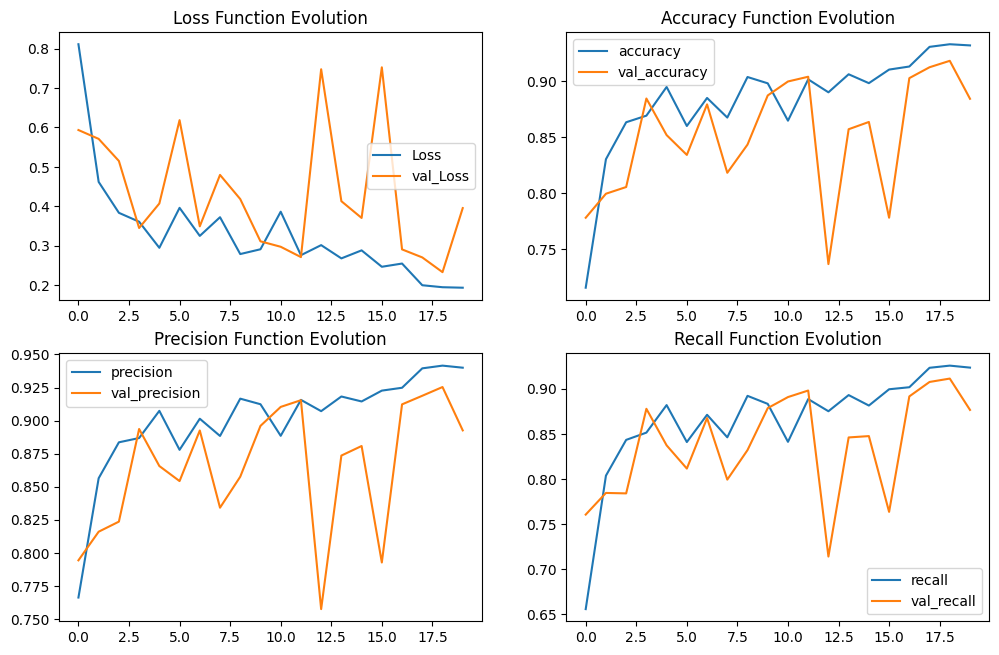

In [31]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_densenet.history['loss'], label='Loss')
plt.plot(history_densenet.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_densenet.history['accuracy'], label='accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_densenet.history['precision'], label='precision')
plt.plot(history_densenet.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history_densenet.history['recall'], label='recall')
plt.plot(history_densenet.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

125/125 [==============================] - 7s 57ms/step - loss: 0.3954 - accuracy: 0.8845 - precision: 0.8926 - recall: 0.8765
Test Accuracy : 88.45%
125/125 [==============================] - 9s 57ms/step


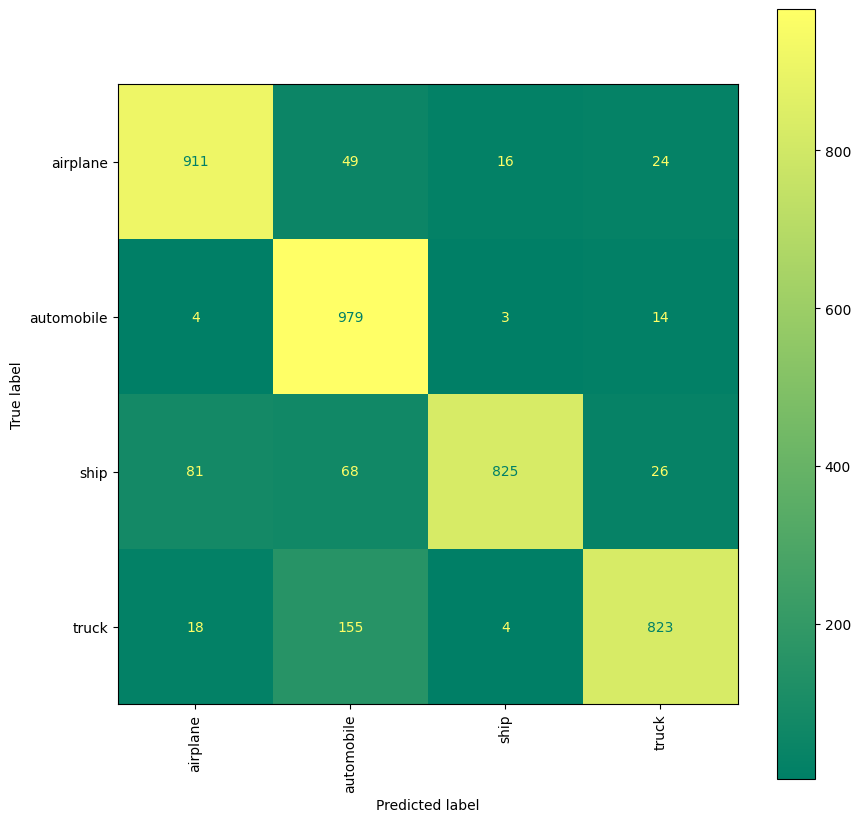

In [32]:
evaluation = model_densenet.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model_densenet.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_name)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

125/125 [==============================] - 7s 57ms/step


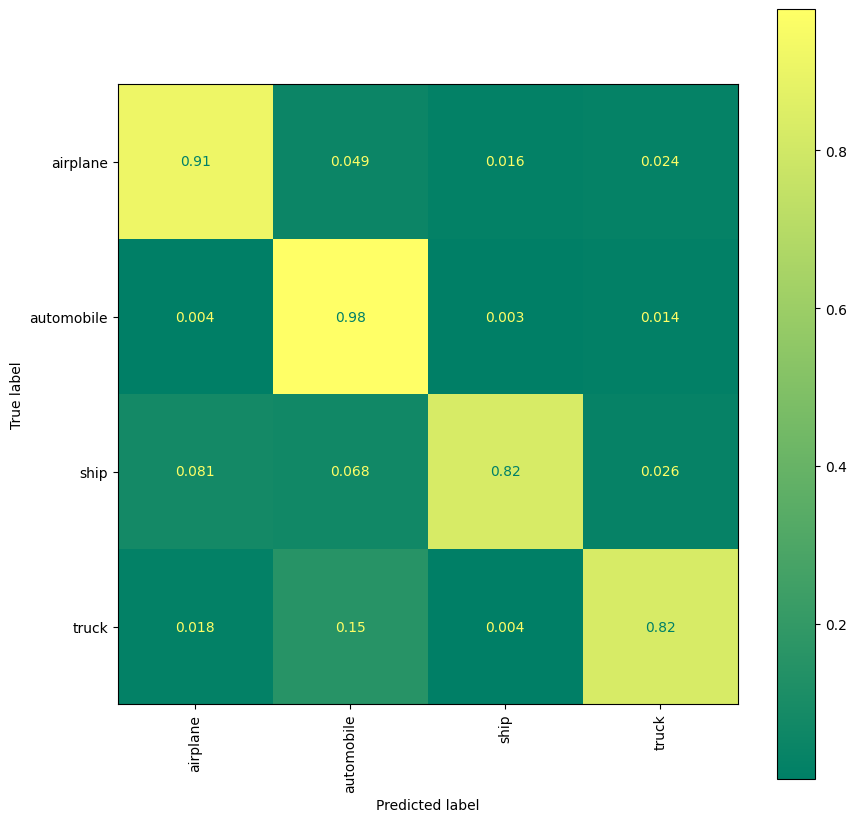

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model and print the test accuracy
evaluation = model_densenet.evaluate(X_test, y_cat_test)
y_pred = model_densenet.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes_name)

# Plot the confusion matrix with values between 0 and 1
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1000
           1       0.78      0.98      0.87      1000
           8       0.97      0.82      0.89      1000
           9       0.93      0.82      0.87      1000

    accuracy                           0.88      4000
   macro avg       0.90      0.88      0.88      4000
weighted avg       0.90      0.88      0.88      4000

